# Copyright Netherlands eScience Center <br>
** Function     : Calculate AMET as the residual of net flux at TOA and surface ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.09.24 ** <br>
** Last Update  : 2018.09.24 ** <br>
Description  : This script serves to calculate the meridional energy transport in the atmosphere as the residual of net radiation flux at top of the atmosphere and the net surface flux at the sea surface. The fields are estimated from ERA-Interim.<br>
Return Values : jpeg <br>

In [10]:
%matplotlib inline

import sys
sys.path.append("/home/yang/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2017
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [11]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'HoF' : 334,        # heat of fusion of ice [KJ/Kg] 
            'rho_ice' : 0.91    # density of sea ice [g/cm3]
            }

In [12]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    output_path = '/home/yang/NLeSC/Computation_Modeling/Bjerknes/Compensation/dataExpo/AMET_res_div'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI_fields,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_AMET = Dataset(os.path.join(datapath,
                                'era_model_subdaily_1979_2016_amet.nc'))
    dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                       'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 3D fields [year, month, lat]
    # since OMET is from 20N - 90N, AMET is from 90N to 20N, we have to reverse it
    # for interpolation, x should be monotonically increasing
    AMET_div_int_ERAI = dataset_ERAI_AMET.variables['E_total_int'][:]/1000 # from Tera Watt to Peta Watt
    # 4D fields [year, month, level, lat]
    rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:-1,:,:,:]
    rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:-1,:,:,:]
    rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:-1,:,:,:]
    rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:-1,:,:,:]
    SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:-1,:,:,:]
    SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:-1,:,:,:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_ERAI = rad_short_surf_ERAI + rad_long_surf_ERAI + SFlux_sensible_ERAI + SFlux_latent_ERAI
    net_flux_toa_ERAI = rad_short_toa_ERAI + rad_long_toa_ERAI
    # other dimensions
    year_ERAI = dataset_ERAI_AMET.variables['year']
    latitude_AMET_ERAI = dataset_ERAI_AMET.variables['latitude'][:]
    latitude_fields_ERAI = dataset_ERAI_fields_flux.variables['latitude'][:]
    longitude_fields_ERAI = dataset_ERAI_fields_flux.variables['longitude'][:]
    # area weighted surface flux
    net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float) # unit W
    net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI /
                                            360) / len(longitude_fields_ERAI) 
    dy = np.pi * constant['R'] / len(latitude_fields_ERAI)
    for i in np.arange(len(latitude_fields_ERAI)):
        # change the unit to terawatt
        net_flux_surf_ERAI_area[:,:,i,:] = net_flux_surf_ERAI[:,:,i,:]* dx[i] * dy / 1E+12
        net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:]* dx[i] * dy / 1E+12

*********************** extract variables *************************


In [13]:
    print ('Compute AMET as the residuals of net flux at TOA & surface.')
    # take the zonal mean of flux
    net_flux_surf_ERAI_int = np.sum(net_flux_surf_ERAI_area,3) / 1000 # PW
    net_flux_toa_ERAI_int = np.sum(net_flux_toa_ERAI_area,3) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_ERAI = np.zeros(net_flux_surf_ERAI_int.shape)
    for i in np.arange(len(latitude_fields_ERAI)-1):
        AMET_res_ERAI[:,:,i] = -(np.sum(net_flux_toa_ERAI_int[:,:,0:i+1],2) -
                                np.sum(net_flux_surf_ERAI_int[:,:,0:i+1],2))
    print (AMET_res_ERAI.shape)

Compute AMET as the residuals of net flux at TOA & surface.
(38, 12, 241)


In [14]:
    print ('Prepare data for plots!')
    # time series for comparison
    AMET_div_int_ERAI_series = AMET_div_int_ERAI.reshape(len(year_ERAI)*12,
                                                         len(latitude_AMET_ERAI))
    AMET_res_int_ERAI_series = AMET_res_ERAI.reshape(len(year_ERAI)*12,
                                                         len(latitude_fields_ERAI))

Prepare data for plots!


*******************  postprocess  *********************
***********!@#$%^&*  AMET residual & divergence !@#$%^&***********


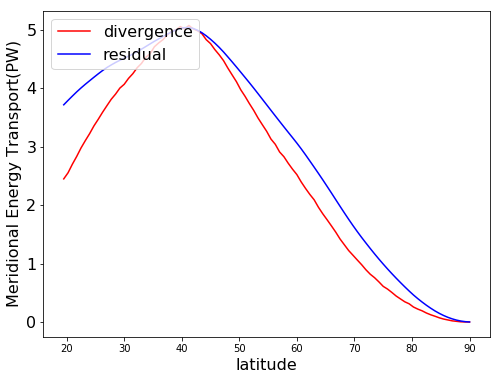

In [14]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  AMET residual & divergence 20N - 90N !@#$%^&***********')
    fig1 = plt.figure()
    fig1.set_size_inches(8, 6)
    plt.plot(latitude_AMET_ERAI, np.mean(AMET_div_int_ERAI_series,0),'r-',
             linewidth=1.5,label='divergence')
    plt.plot(latitude_fields_ERAI[:95], np.mean(AMET_res_int_ERAI_series[:,:95],0), 'b-',
             linewidth=1.5, label='residual')
    plt.xlabel("latitude",fontsize=16)
   #plt.xticks(,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig1.savefig(os.path.join(output_path,'AMET_res_div.png'),dpi=300)
    plt.close(fig1)

*******************  postprocess  *********************
***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********


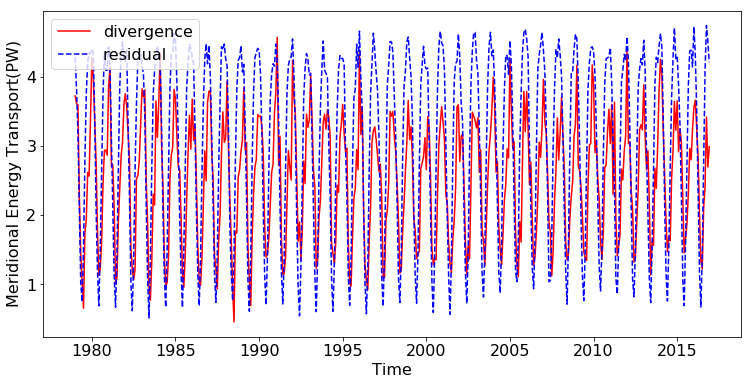

mean of divergence
2.52137809887267
mean of residual
3.0599991087937206


In [15]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  AMET residual & divergence 60N!@#$%^&***********')
    index_year = np.arange(1980,year_ERAI[-1]+1,5)
    index = np.arange(1,457,1) # 1979 - 2016
    
    fig2 = plt.figure()
    fig2.set_size_inches(12.5, 6)
    plt.plot(index[:], AMET_div_int_ERAI_series[:,40],'r-',
             linewidth=1.5,label='divergence')
    plt.plot(index[:], AMET_res_int_ERAI_series[:,40],
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig2.savefig(os.path.join(output_path,'AMET_res_div_60N.png'),dpi=300)
    plt.close(fig2)
    # statistics
    print('mean of divergence')
    print(np.mean(AMET_div_int_ERAI_series[:,40]))
    print('mean of residual')
    print(np.mean(AMET_res_int_ERAI_series[:,40]))

*******************  postprocess  *********************
***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


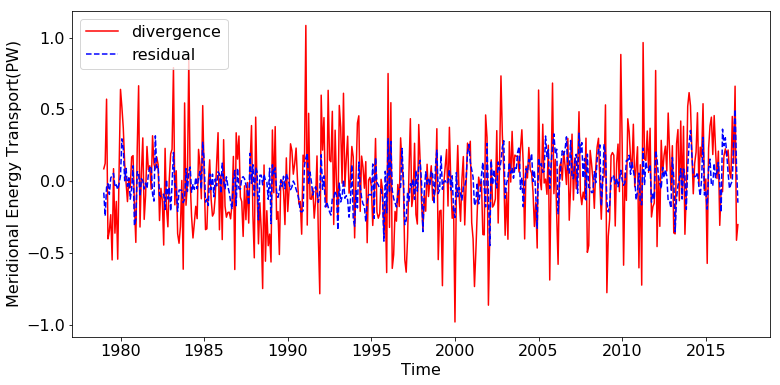

std of divergence
0.3198688764850559
std of residual
0.1402194915898489


In [9]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********')
    # take anomalies
    stat_AMET_div_ERAI = meta.statistics.operator(AMET_div_int_ERAI_series[:,40])
    stat_AMET_div_ERAI.anomaly(Dim_month=False)
    stat_AMET_res_ERAI = meta.statistics.operator(AMET_res_int_ERAI_series[:,40])
    stat_AMET_res_ERAI.anomaly(Dim_month=False)    
    
    fig3 = plt.figure()
    fig3.set_size_inches(12.5, 6)
    plt.plot(index[:], stat_AMET_div_ERAI._anomaly,'r-',
             linewidth=1.5,label='divergence')
    plt.plot(index[:], stat_AMET_res_ERAI._anomaly,
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig3.savefig(os.path.join(output_path,'AMET_res_div_anomaly_60N.png'),dpi=300)
    plt.close(fig3)
    # statistics
    print('std of divergence')
    print(np.std(stat_AMET_div_ERAI._anomaly))
    print('std of residual')
    print(np.std(stat_AMET_res_ERAI._anomaly))    

*******************  postprocess  *********************
***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


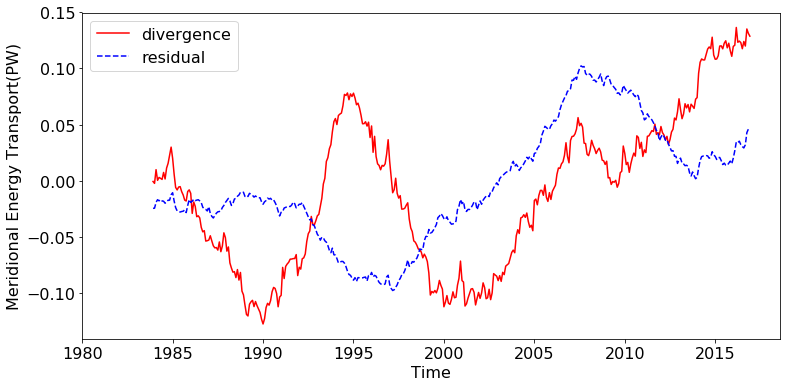

std of divergence
0.06799931657497507
std of residual
0.05109024224636256


In [17]:
    print ('*******************  postprocess  *********************')
    print ('***********!@#$%^&*  AMET residual & divergence anomalies 60N!@#$%^&***********')
    # take anomalies
    stat_AMET_div_ERAI = meta.statistics.operator(AMET_div_int_ERAI_series[:,40])
    stat_AMET_div_ERAI.anomaly(Dim_month=False)
    stat_AMET_div_ERAI.lowpass()
    
    stat_AMET_res_ERAI = meta.statistics.operator(AMET_res_int_ERAI_series[:,40])
    stat_AMET_res_ERAI.anomaly(Dim_month=False)    
    stat_AMET_res_ERAI.lowpass()
    
    fig4 = plt.figure()
    fig4.set_size_inches(12.5, 6)
    plt.plot(index[59:], stat_AMET_div_ERAI._lowpass,'r-',
             linewidth=1.5,label='divergence')
    plt.plot(index[59:], stat_AMET_res_ERAI._lowpass,
             'b--', linewidth=1.5, label='residual')
    plt.xlabel("Time",fontsize=16)
    plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
    plt.ylabel("Meridional Energy Transport(PW)",fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(frameon=True, loc=2, prop={'size': 16})
    plt.show()
    fig4.savefig(os.path.join(output_path,'AMET_res_div_anomaly_lowpass_5y_60N.png'),dpi=300)
    plt.close(fig4)
    # statistics
    print('std of divergence')
    print(np.std(stat_AMET_div_ERAI._lowpass))
    print('std of residual')
    print(np.std(stat_AMET_res_ERAI._lowpass))